In [1]:
import kagglehub
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, VGG16, VGG19, ResNet152
import os
import pandas as pd
!pip install nibabel
import nibabel as nib
import matplotlib.pyplot as plt

scans_path = kagglehub.dataset_download("drakonyx/adni-processed")
labels_path = kagglehub.dataset_download("dhyanavsiddhapuria/labels-scans")

labels = pd.read_csv('/kaggle/input/labels-scans/Labels.csv')
labels.head()

2025-07-04 14:57:27.435416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751641047.618524      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751641047.677415      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I112538,941_S_1311,MCI,M,70,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,6/01/2008,NiFTI,NaN
1,I97341,941_S_1311,MCI,M,70,m06,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,9/27/2007,NiFTI,NaN
2,I97327,941_S_1311,MCI,M,69,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/02/2007,NiFTI,NaN
3,I75150,941_S_1202,CN,M,78,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,8/24/2007,NiFTI,NaN
4,I105437,941_S_1202,CN,M,79,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,2/28/2008,NiFTI,NaN


In [2]:
paths = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.csv'):
            continue
        paths.append(os.path.join(dirname, filename))
len(paths)

459

In [7]:
def prepare_for_training(slc, image_size):
    ## to tensor
    slice_tensor = tf.convert_to_tensor(slc, dtype=tf.float32)
    slice_tensor = tf.expand_dims(slc, axis=-1)

    ## resize
    resized = tf.image.resize(slice_tensor, [image_size, image_size])

    return resized ## is a tensor

In [3]:
def get_label(path):
    image_id = path.split('/')[6]
    #print(image_id)
    image_data_ids = labels['Image Data ID']
    for i in range(len(image_data_ids)):
        curr_id = image_data_ids[i]
        if curr_id == image_id:
            label = labels['Group'][i]
    if label == 'AD':
        label = 2
    elif label == 'MCI':
        label = 1
    elif label == 'CN':
        label = 0
    return label
#print(get_label(paths[10]))
#print(paths[0])

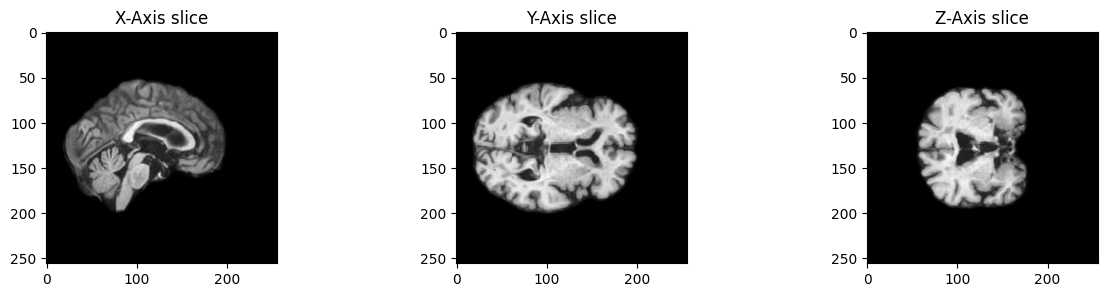

In [4]:
def plot_slices(meta_data, index_array, size=(15,3)):
    figures, axes = plt.subplots(1, 3, figsize = size)
    img_slice = [ meta_data[index_array[0], :, :], meta_data[:, index_array[1], :], meta_data[:, :, index_array[2]] ]

    ## Sagittal ( Y-Z )
    axes[0].imshow(img_slice[0], cmap='gray')
    axes[0].set_title("X-Axis slice")

    ## Coronal ( X-Z )
    axes[1].imshow(img_slice[1], cmap='gray')
    axes[1].set_title("Y-Axis slice")

    # Axial ( X-Y )
    axes[2].imshow(img_slice[2], cmap='gray')
    axes[2].set_title("Z-Axis slice")

    plt.show()

scan = nib.load(paths[10])
data = scan.get_fdata()
plot_slices( data, [data.shape[0]//2, data.shape[1]//2, data.shape[2]//2] )

# 2D Models #

VGG-16

In [5]:
# 1. Prepare the input shape
IMG_SIZE = 224

# 2. Define the model with VGG16 base
def build_vgg16_model():
    # Input has 1 channel, VGG16 expects 3 -> repeat channels
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = layers.Concatenate()([inputs, inputs, inputs])  # Convert grayscale to RGB

    # Load VGG16 without top
    base_model = VGG16(include_top=False, input_tensor=x, weights='imagenet')
    base_model.trainable = False  # Freeze base

    # Add custom head
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(3, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=output)
    return model

# 3. Build and compile the model
vgg16_model = build_vgg16_model()
vgg16_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

I0000 00:00:1751621028.875201      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


VGG 19

In [6]:
# 1. Prepare the input shape
IMG_SIZE = 224

# 2. Define the model with VGG19 base
def build_vgg19_model():
    # Input has 1 channel, VGG19 expects 3 -> repeat channels
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = layers.Concatenate()([inputs, inputs, inputs])  # Convert grayscale to RGB

    # Load VGG19 without top
    base_model = VGG19(include_top=False, input_tensor=x, weights='imagenet')  # Changed here
    base_model.trainable = False  # Freeze base

    # Add custom head
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    output = layers.Dense(3, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=output)
    return model

# 3. Build and compile the model
vgg19_model = build_vgg19_model()
vgg19_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Resnet-50

In [25]:
# 1. Prepare the input shape
IMG_SIZE = 224

# 2. Define the model with ResNet base
def build_resnet50_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = layers.Concatenate()([inputs, inputs, inputs])  # Convert 1-channel to 3-channel

    base_model = ResNet50(include_top=False, input_tensor=x, weights='imagenet')
    base_model.trainable = False

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.6)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.6)(x)
    output = layers.Dense(3, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=output)
    return model

# Instantiate and compile model
model_resnet50 = build_resnet50_model()
model_resnet50.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                       loss='categorical_crossentropy',
                       metrics=['accuracy']
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Resnet 152

In [23]:
# 1. Prepare the input shape
IMG_SIZE = 224

# 2. Define the model with ResNet152 base
def build_resnet152_model():
    # Input has 1 channel, ResNet expects 3 -> repeat channels
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = layers.Concatenate()([inputs, inputs, inputs])  # Convert grayscale to RGB

    # Load ResNet152 without the top classifier
    base_model = ResNet152(include_top=False, input_tensor=x, weights='imagenet')
    base_model.trainable = False  # Freeze base model initially

    # Add custom classification head
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    output = layers.Dense(3, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=output)
    return model

# 3. Build and compile the model
resnet152_model = build_resnet152_model()
resnet152_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 2D  Models Training #

In [26]:
epochs = 20

for epoch in range(epochs):
    combined = list(zip(paths))
    np.random.shuffle(combined)
    paths = [p[0] for p in combined]

    if epoch == 5:
        model_resnet50.trainable = True
        model_resnet50.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
    
    for i in range(len(paths)):
        path = paths[i]
        scan = nib.load(path)
        data = scan.get_fdata()
        affine = scan.affine

        data = data / np.max(data)

        # Take middle axial slice
        middle_slice = data[data.shape[0] // 2, :, :]
        middle_slice = prepare_for_training(middle_slice, IMG_SIZE)   # (224, 224, 1)

        # Add batch dimension
        middle_slice = np.expand_dims(middle_slice, axis=0)           # (1, 224, 224, 1)

        # Prepare label
        label = get_label(path)
        one_hot = np.zeros(3)
        one_hot[label] = 1

        one_hot = np.expand_dims(one_hot, axis=0)  # shape becomes (1, 3)

        #print(one_hot)
        #print(label)

        # Train
        loss, acc = model_resnet50.train_on_batch(middle_slice, one_hot)

        # if i == 0:
        #     print(f'Epoch: {epoch+1}, Start Accuracy: {final_accuracy}')
        if i == (len(paths))-1:
            print(f'After {epoch+1} epoch, accuracy={acc:.4f}% and loss={loss:.2f}')

After 1 epoch, accuracy=0.4749% and loss=4.53
After 2 epoch, accuracy=0.4782% and loss=2.80
After 3 epoch, accuracy=0.4815% and loss=2.22
After 4 epoch, accuracy=0.4837% and loss=1.92
After 5 epoch, accuracy=0.4850% and loss=1.75
After 6 epoch, accuracy=0.4902% and loss=1.04
After 7 epoch, accuracy=0.4902% and loss=1.04
After 8 epoch, accuracy=0.4902% and loss=1.04
After 9 epoch, accuracy=0.4902% and loss=1.04
After 10 epoch, accuracy=0.4902% and loss=1.04
After 11 epoch, accuracy=0.4902% and loss=1.04
After 12 epoch, accuracy=0.4902% and loss=1.04
After 13 epoch, accuracy=0.4902% and loss=1.04
After 14 epoch, accuracy=0.4902% and loss=1.04
After 15 epoch, accuracy=0.4902% and loss=1.04
After 16 epoch, accuracy=0.4902% and loss=1.04
After 17 epoch, accuracy=0.4902% and loss=1.04
After 18 epoch, accuracy=0.4902% and loss=1.04
After 19 epoch, accuracy=0.4902% and loss=1.04
After 20 epoch, accuracy=0.4902% and loss=1.04


# 3D Models #

In [6]:
IMG_SIZE = 120  # Input shape will be (224, 224, 224, 1)

def inflate_conv_weights(conv2d_weights, depth=3):
    """Inflate 2D conv weights to 3D by repeating along the depth axis."""
    kernel, bias = conv2d_weights
    kernel3d = tf.repeat(kernel[:, :, tf.newaxis, :, :], depth, axis=2)
    return [kernel3d, bias]

def conv3d_bn(x, filters, kernel_size, strides=(1,1,1), padding='same', name=None):
    x = layers.Conv3D(filters, kernel_size, strides=strides, padding=padding, use_bias=False, name=name)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def build_inflated_resnet18_3d(input_shape=(IMG_SIZE, IMG_SIZE, IMG_SIZE, 1), num_classes=3):
    inputs = layers.Input(shape=input_shape)

    # Repeat channel to match ResNet pretrained input (RGB → 3)
    x = layers.Concatenate()([inputs, inputs, inputs])  # (H, W, D, 3)

    # Initial convolutional block
    x = conv3d_bn(x, 64, kernel_size=7, strides=(2, 2, 2), padding='same', name='conv1_3d')
    x = layers.MaxPooling3D(pool_size=3, strides=2, padding='same')(x)

    # Simplified ResNet block (e.g., ResNet-18 style, 2 convs per block)
    def residual_block(x, filters, strides=(1,1,1)):
        shortcut = x
        x = conv3d_bn(x, filters, kernel_size=3, strides=strides)
        x = conv3d_bn(x, filters, kernel_size=3)
        if shortcut.shape[-1] != x.shape[-1] or strides != (1,1,1):
            shortcut = conv3d_bn(shortcut, filters, kernel_size=1, strides=strides)
        return layers.Add()([shortcut, x])

    # Stack ResNet layers
    for filters, reps in zip([64, 128, 256, 512], [2, 2, 2, 2]):
        for i in range(reps):
            x = residual_block(x, filters, strides=(2,2,2) if i==0 else (1,1,1))

    # Classification head
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)

    return model

inflated_resnet3d = build_inflated_resnet18_3d()
inflated_resnet3d.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
#inflated_resnet3d.summary()

I0000 00:00:1751626746.828735      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


# 3D Models Training #

In [ ]:
from scipy.ndimage import zoom

def resize_3d(data, output_shape):

    zoom_factors = [o / i for o, i in zip(output_shape, data.shape)]
    resized_data = zoom(data, zoom_factors, order=1)  # order=1: linear interpolation

    return resized_data

# Define input shape expected by model
data_size = (IMG_SIZE, IMG_SIZE, IMG_SIZE)  # Should match model input
epochs = 15

for epoch in range(epochs):
    for i in range(len(paths)):
        path = paths[i]
        scan = nib.load(path)
        data = scan.get_fdata()

        # Normalize data (optional but recommended)
        data = (data - np.mean(data)) / (np.std(data) + 1e-8)
        
        # Resize 3D volume
        data_resized = resize_3d(data, data_size)

        # Add channel dimension: (H, W, D, 1)
        data_resized = np.expand_dims(data_resized, axis=-1)

        # Add batch dimension: (1, H, W, D, 1)
        data_resized = np.expand_dims(data_resized, axis=0)

        # Prepare label
        label = get_label(path)
        label = np.array([label], dtype=np.int32)  # shape: (1,)

        loss, acc = inflated_resnet3d.train_on_batch(data_resized, label)

        if i == len(paths)-1:
            print(f"After epoch {epoch+1}, accuracy = {acc:.4f}, loss = {loss:.4f}")

I0000 00:00:1751626766.894952      35 service.cc:148] XLA service 0x25c27e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751626766.895688      35 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751626768.207919      35 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751626777.493636      35 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


After epoch 1, accuracy = 0.4052, loss = 13.7392
After epoch 2, accuracy = 0.4444, loss = 7.4008
After epoch 3, accuracy = 0.4575, loss = 5.2881
After epoch 4, accuracy = 0.4641, loss = 4.2318
After epoch 5, accuracy = 0.4680, loss = 3.5981
